In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams["figure.figsize"] = (20, 10)
import quantstats as qs
import os

In [2]:


# Path to the folder containing the Parquet files
folder_path = r'C:\Users\Sohum\Downloads\ohlcv processed'

# Dictionaries to store DataFrames
dataframes = {
    'Open': [],
    'High': [],
    'Low': [],
    'Close': [],
    'Volume': []
}

# Function to categorize files based on keywords in file names
def categorize_file(file_name):
    file_name_lower = file_name.lower()
    if 'open' in file_name_lower:
        return 'Open'
    elif 'high' in file_name_lower:
        return 'High'
    elif 'low' in file_name_lower:
        return 'Low'
    elif 'close' in file_name_lower:
        return 'Close'
    elif 'volume' in file_name_lower:
        return 'Volume'
    else:
        return None

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.parquet'):
        category = categorize_file(file_name)
        if category:
            # Construct full file path
            file_path = os.path.join(folder_path, file_name)
            # Read the Parquet file into a DataFrame
            df = pd.read_parquet(file_path)
            # Append the DataFrame to the corresponding category list
            dataframes[category].append(df)

# Optionally, concatenate DataFrames within each category
for category in dataframes:
    if dataframes[category]:
        dataframes[category] = pd.concat(dataframes[category], ignore_index=False)
    else:
        dataframes[category] = pd.DataFrame()


In [3]:
OPEN = dataframes['Open']
HIGH = dataframes['High']
LOW = dataframes['Low']
CLOSE = dataframes['Close']
VOLUME = dataframes['Volume']


common_indices = OPEN.index.intersection(HIGH.index).intersection(LOW.index).intersection(CLOSE.index).intersection(VOLUME.index)

# Find the common columns (symbols) across all DataFrames
common_columns = OPEN.columns.intersection(HIGH.columns).intersection(LOW.columns).intersection(CLOSE.columns).intersection(VOLUME.columns)

# Keep only the common indices and columns
OPEN = OPEN.loc[common_indices, common_columns]
HIGH = HIGH.loc[common_indices, common_columns]
LOW = LOW.loc[common_indices, common_columns]
CLOSE = CLOSE.loc[common_indices, common_columns]
VOLUME = VOLUME.loc[common_indices, common_columns]


In [4]:
%%time
true_range = pd.DataFrame(index=common_indices, columns=common_columns)
for col in common_columns:
    tr1 = HIGH[col] - LOW[col]
    tr2 = (HIGH[col] - CLOSE[col].shift(1)).abs()
    tr3 = (LOW[col] - CLOSE[col].shift(1)).abs()
    true_range[col] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

atr = true_range.rolling(window=14).mean()


In [5]:
ATR = atr

In [477]:
dates = sorted(list(set(OPEN.index.date)))

In [228]:
def filter_dates_by_years(dates, start_year, end_year):
    # Ensure dates are in pandas datetime format
    dates = pd.to_datetime(dates)
    
    # Filter dates within the specified year range
    filtered_dates = [date for date in dates if start_year <= date.year <= end_year]
    return pd.to_datetime(filtered_dates).date
   

In [478]:
dates = filter_dates_by_years(dates,2021,2025)

In [484]:
slippage = 0.001
(1-slippage)/(1+slippage)

0.9980019980019981

In [486]:
charges = 0.0002
threshold = 0.0
slippage = 0.001
minutes = 90
slippage_loss = (1-slippage)/(1+slippage)
max_positions = 5
daily_stats = []

masterList = []
for j in tqdm(range(len(dates))):
    try:
        todayCLOSE = CLOSE[CLOSE.index.date==dates[j]]
        todayOPEN = OPEN[OPEN.index.date==dates[j]]
        splitsCLOSE = np.array_split(todayCLOSE, minutes)
        splitsOPEN = np.array_split(todayOPEN, minutes)
        lst = []
        for i in range(len(splitsCLOSE)-1):
            split_ranks = (splitsCLOSE[i].pct_change().mean() * len(splitsCLOSE[i])).dropna().sort_values(ascending=False)
            split_ranks_winners = split_ranks[split_ranks>threshold].head(max_positions)
            split_ranks_losers = split_ranks[split_ranks<-threshold].tail(max_positions)
            winners  = list(split_ranks_winners.index)
            losers  = list(split_ranks_losers.index)
            long_returns = splitsCLOSE[i+1][losers].iloc[-1]/splitsCLOSE[i+1][losers].iloc[0]  - 1
            short_returns = splitsCLOSE[i+1][winners].iloc[-1]/splitsCLOSE[i+1][winners].iloc[0]  - 1

            daily_stats.append({'Winners': split_ranks_winners.index.to_list(),
                               'Losers': split_ranks_losers.index.to_list(),
                               'Winner Returns': long_returns.values,
                               'Loser Returns': short_returns.values})

            short_returns = -5 * (slippage_loss * (short_returns - (2+short_returns) * charges)).mean()
            long_returns = 5 * (slippage_loss * (long_returns - (2+long_returns) * charges)).mean()

            lst.append({'Date' : dates[0],
                        'Entry' : splitsOPEN[i+1].index[0],
                        'Exit' : splitsOPEN[i+1].index[-1],
                           'LongReturns': long_returns,
                           'ShortReturns': short_returns,
                           })

    except Exception as e:
        print(e)
    Dfx = pd.DataFrame(lst)
    Dfx['Date']  = pd.to_datetime(Dfx['Date'])
    Dfx.set_index('Date',inplace=True)

    long_nett = (0 + Dfx.fillna(0)['LongReturns']).cumsum().iloc[-1] 
    short_nett = (0 + Dfx.fillna(0)['ShortReturns']).cumsum().iloc[-1]
    masterList.append({'Date' : dates[j],
                      'Long' : long_nett,
                      'Short' : short_nett})


  0%|          | 0/852 [00:00<?, ?it/s]

In [466]:
splitsCLOSE = np.array_split(todayCLOSE, 360)
for i in range(len(splitsCLOSE)):
    print(len(splitsCLOSE[i]))

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [487]:
PerformanceSheet = pd.DataFrame(masterList).set_index('Date')
PerformanceSheet.index = pd.to_datetime(PerformanceSheet.index)

<Axes: xlabel='Date'>

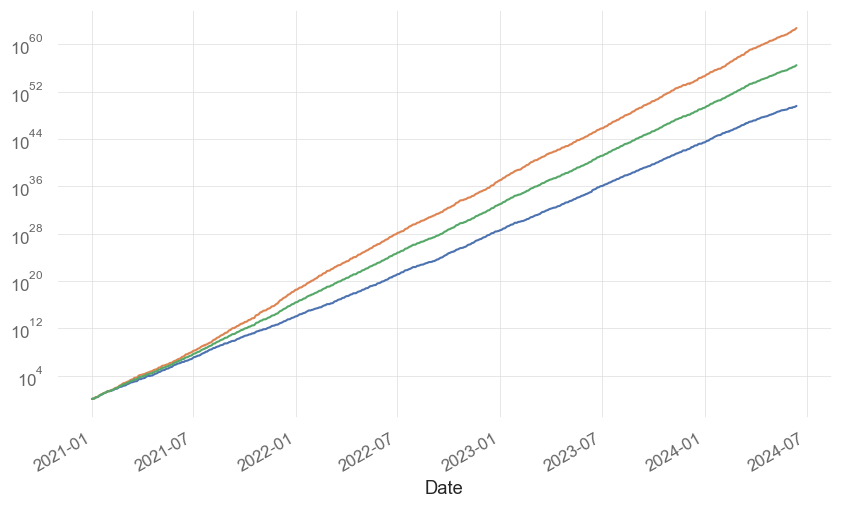

In [488]:
(1 - PerformanceSheet['Long']).cumprod().plot(logy=True)
(1 + PerformanceSheet['Short']).cumprod().plot(logy=True)
(1 + (-PerformanceSheet['Long'] + PerformanceSheet['Short'])/2).cumprod().plot(logy=True)


In [491]:
PerformanceSheet['Short'].max()

0.5633989540136376